# Calibration of Black and Scholes, Merton, Kou, Variance Gamma parameters
This notebook aims to find the optimal parameters of **Black-Scholes**, **Merton Jump Diffusion**, **Kou Jump Diffusion** and **Variance Gamma** models. To do so, we compute the european option prices using **closed formulas**, available for all the 4 models, and the **Fast Fourier Transform** for the VG model. Given these theoretical prices, the **implied volatilities** are computed comparing them with real market prices, minimizing their difference. Then we estimate the additional parameters of each model, using the python module `scipy.optimize`.

*reference: https://github.com/cantaro86/Financial-Models-Numerical-Methods/tree/master*


In [1]:
from functions.MERTONpricer import Merton_pricer
from functions.BSpricer import BS_Pricer
from functions.KOUpricer import Kou_pricer
from functions.VGpricer import VG_pricer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy as scp
import scipy.stats as ss
import scipy.optimize as scpo
import time

random.seed(100)

Let's start retrieving historical prices for **european call** and **put** options starting from date **2016-01-20** and expiring **1 year** later. All the data have been collected from [OptionsDX](https://www.optionsdx.com/shop/) and preprocessed in `plainvanilla.py` module. Only options such that
$$ K = S0 \pm 1000 $$ have been selected.

In [2]:
df_call = pd.read_csv('data/options_spx_call_2016.csv')
df_put = pd.read_csv('data/options_spx_put_2016.csv')
print(f'NUM OF CALL OPTS: {df_call.shape[0]}')
print(df_call.head(5))
print(f'NUM OF PUT OPTS: {df_put.shape[0]}')
print(df_put.tail(5))

NUM OF CALL OPTS: 32
   QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE   C_BID  C_ASK  STRIKE     C_IV
0  2016-01-20          1859.48  2017-01-20  407.90  412.0  1475.0  0.26333
1  2016-01-20          1859.48  2017-01-20  387.60  391.7  1500.0  0.26134
2  2016-01-20          1859.48  2017-01-20  367.60  371.6  1525.0  0.25894
3  2016-01-20          1859.48  2017-01-20  347.91  351.9  1550.0  0.25628
4  2016-01-20          1859.48  2017-01-20  328.30  332.3  1575.0  0.25258
NUM OF PUT OPTS: 32
    QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE   P_BID   P_ASK  STRIKE     P_IV
27  2016-01-20          1859.48  2017-01-20  340.20  344.60  2150.0  0.13933
28  2016-01-20          1859.48  2017-01-20  360.29  364.70  2175.0  0.13211
29  2016-01-20          1859.48  2017-01-20  380.59  385.19  2200.0  0.12159
30  2016-01-20          1859.48  2017-01-20  401.89  406.50  2225.0  0.10806
31  2016-01-20          1859.48  2017-01-20  423.79  428.50  2250.0  0.00031


The dataframes **df_calls** and **df_put** contain both 83 options sorted by strike price. For our purpose, using the $25\%$ of these DFs is enough and can lead to very good results. Thus, we sample the rows and then reformulate the dataframes adding **Midpoint** and **Spread** columns.

In [3]:
calls = df_call.sample(frac=0.5, replace=False).sort_index().reset_index(drop=True)
puts = df_put.sample(frac=0.5, replace=False).sort_index().reset_index(drop=True)

calls['C_Midpoint'] = abs(calls['C_BID'] + calls['C_ASK']) / 2
puts['P_Midpoint'] = abs(puts['P_BID'] + puts['P_ASK']) / 2
calls['C_Spread'] = calls['C_BID'] - calls['C_ASK']
puts['P_Spread'] = puts['P_BID'] - puts['P_ASK']

q = 0           # dividend yield
r = 0.02        # risk-free interest rate
sigma = 0.2     #volatility (variance of diffusion process)
S0 = calls.iloc[0]['UNDERLYING_LAST']
T = 1           # time-to-maturity
call_strikes = calls['STRIKE']    # array of K for call options
put_strikes = puts['STRIKE']      # array of K for put options
exercise = 'european'

call_prices = calls['C_Midpoint']
put_prices = puts['P_Midpoint']

The following code snippet initializes objects of class *BS_pricer*, *Merton_pricer*, *Kou_pricer*, *VG_pricer* with default values as parameters. Then it computes the theoretical call prices using closed formulas of each 4 models, with strike prices given by the *call_strikes* array. Additionally, we use the **Midpoint** price as the option market prices.P

In [4]:
BS = BS_Pricer(S0=S0, r=r, q = q, sigma=sigma, ttm=T, exercise=exercise, K=None)
Merton = Merton_pricer(S0=S0, K=None, ttm=T, r=0.05, q = q, sigma=0.12, lambd=0.5, meanJ=-0.1, stdJ=0.2, exercise=exercise)
Kou = Kou_pricer(S0=S0, K=None, ttm=T, r=r, sigma=0.12, lambd=0.5, p=0.6, eta1=10, eta2=5, exercise=exercise)
VG = VG_pricer(S0, K=None, ttm=T, r=r, q=q, sigma=0.15, theta=-0.2, nu=0.2, exercise=exercise)

call_th_prices = pd.DataFrame(columns=['Strike','BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
call_th_prices['Strike'] = call_strikes

for i, K in enumerate(call_strikes):
    bs = BS.closed_formula_call(K)
    mert = Merton.closed_formula_call(K)
    kou = Kou.closed_formula_call(K)
    vg = VG.closed_formula_call(K)
    call_th_prices.iloc[i, 1:] = [bs, mert, kou, vg]

print(f'Theoretical call options prices:')
print(call_th_prices.head(5)) #print(call_th_prices.tail(4))

Theoretical call options prices:
   Strike BlackScholes      Merton         Kou VarianceGamma
0  1475.0   429.938246  474.498455  431.003001    418.830502
1  1525.0    387.86823  431.742091  386.247447    373.862891
2  1550.0   367.551944  410.722677  364.317303     352.15614
3  1575.0    347.75648  389.971732  342.750747    331.061293
4  1625.0   309.840176  349.381334  300.930247    290.957458


Same for put prices.

In [5]:
put_th_prices = pd.DataFrame(columns=['Strike','BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
put_th_prices['Strike'] = put_strikes

for i, K in enumerate(put_strikes):
    bs = BS.closed_formula_put(K)
    mert = Merton.closed_formula_put(K)
    kou = Kou.closed_formula_put(K)
    vg = VG.closed_formula_put(K)
    put_th_prices.iloc[i, 1:] = [bs, mert, kou, vg]

print(f'Theoretical put options prices:')
print(put_th_prices.head(5))

Theoretical put options prices:
   Strike BlackScholes     Merton        Kou VarianceGamma
0  1500.0    19.492529   20.37145  19.309027      6.929789
1  1550.0    27.379887  25.648285  24.145247     11.984084
2  1600.0    37.348384  32.002052  30.440265     19.480668
3  1625.0     43.18302  35.649149  34.273091     24.300302
4  1725.0    72.697348  54.155314  55.565775     51.706854


### Variance Gamma Fast Fourier Transform
Let's now compare the Closed Forms with the Fast Fourier Transform method for the Variance Gamma model for both call and put options.  The FFT method is explained by Carr, Madan, Chang 1998: *The Variance Gamma Process and Option Pricing*.

In [6]:
c_vg_fft = VG.FFT_call(call_strikes)

for k, a, b in zip(call_strikes, call_th_prices['VarianceGamma'], c_vg_fft):
    print(f'K={k}, CF:{a}, FFT:{b}')

K=1475.0, CF:418.8305015337701, FFT:427.8522917606683
K=1525.0, CF:373.8628906639924, FFT:384.1180791431043
K=1550.0, CF:352.15614027108154, FFT:362.79564203297036
K=1575.0, CF:331.061292954241, FFT:341.88078875612473
K=1625.0, CF:290.9574580233059, FFT:301.41153912388654
K=1725.0, CF:220.3441423695824, FFT:226.8815187730031
K=1775.0, CF:190.18446421089004, FFT:193.34619126502048
K=1800.0, CF:176.39279044360592, FFT:177.61306186070556
K=1825.0, CF:163.43958614957637, FFT:162.6017240428141
K=1850.0, CF:151.3023195279311, FFT:148.33204998599467
K=1900.0, CF:129.36391314928323, FFT:122.07750484515282
K=1925.0, CF:119.4991291380461, FFT:110.1116503323343
K=1975.0, CF:101.80490491410478, FFT:88.51481641175928
K=2125.0, CF:62.42673475260045, FFT:41.594476839163065
K=2150.0, CF:57.502479916795835, FFT:36.1393462733252
K=2200.0, CF:48.78015917464876, FFT:26.953777799759052


In [7]:
p_vg_fft = VG.FFT_put(put_strikes)

for k, a, b in zip(put_strikes, put_th_prices['VarianceGamma'], p_vg_fft):
    print(f'K={k}, CF:{a}, FFT:{b}')

K=1500.0, CF:6.92978904338338, FFT:16.632508427421953
K=1550.0, CF:11.984083896552193, FFT:22.623585658441016
K=1600.0, CF:19.480668090090376, FFT:30.245720002831376
K=1625.0, CF:24.300302146783224, FFT:34.754383247363876
K=1725.0, CF:51.70685382373517, FFT:58.24423022715587
K=1850.0, CF:105.18986514542826, FFT:102.21959560349183
K=1875.0, CF:118.34645458560544, FFT:113.2125625412682
K=1900.0, CF:132.2613924321181, FFT:124.97498412798768
K=1925.0, CF:146.90157525354994, FFT:137.51409644783803
K=1950.0, CF:162.2321611294799, FFT:150.83234159078438
K=2000.0, CF:194.82066520681155, FFT:179.79108358744065
K=2050.0, CF:229.73794560309693, FFT:211.77053407623748
K=2125.0, CF:285.8689155294553, FFT:265.0366576160179
K=2150.0, CF:305.44962752631955, FFT:284.0864938828488
K=2175.0, CF:325.4150595616313, FFT:303.72431911604303
K=2225.0, CF:366.38978654257426, FFT:344.60531914039257


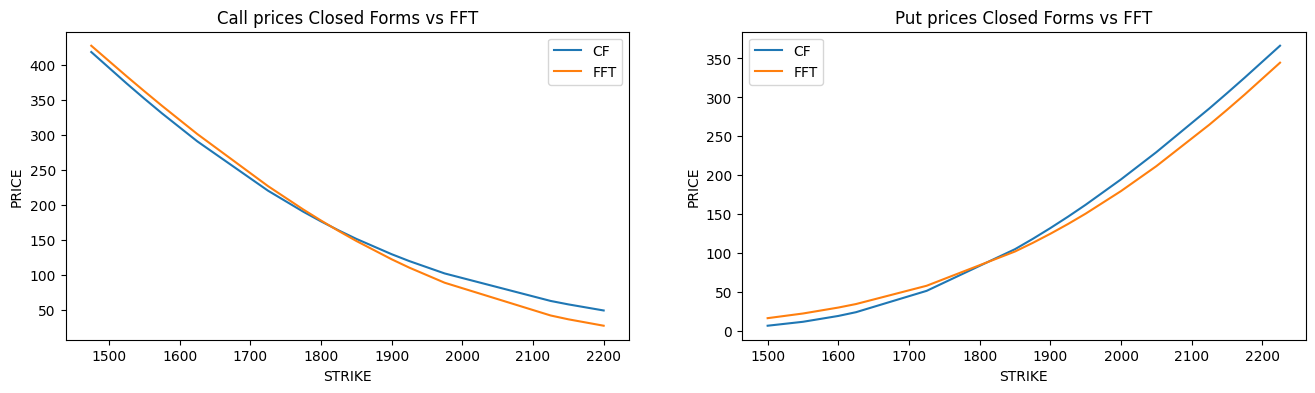

In [8]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.plot(call_strikes, call_th_prices['VarianceGamma'], label='CF')
ax1.plot(call_strikes, c_vg_fft, label='FFT')
ax1.set_title('Call prices Closed Forms vs FFT'); ax1.set_xlabel('STRIKE'); ax1.set_ylabel('PRICE')
# ax1.set_xlim([1400,2000]);ax1.set_ylim([0,800])

ax2.plot(put_strikes, put_th_prices['VarianceGamma'], label='CF')
ax2.plot(put_strikes, p_vg_fft, label='FFT')
ax2.set_title('Put prices Closed Forms vs FFT'); ax2.set_xlabel('STRIKE'); ax2.set_ylabel('PRICE')
ax1.legend(); ax2.legend()

## Implied volatility
The function belows implements $3$ methods to compute implied volatility: [Newton](https://en.wikipedia.org/wiki/Newton%27s_method) method, the [Bisection](https://en.wikipedia.org/wiki/Bisection_method) method and a more advanced one, named [Brent](https://en.wikipedia.org/wiki/Brent%27s_method) method. Apart from the initial guess, there is no substantial difference in the final result between **Newton** and **bisection** methods (*fsolve*). The **Implied Volatility** is that value $\sigma$ that must be inserted into the Black-Scholes (BS) formula in order to retrieve the option price quoted in the market:
    $$ BS(S, K, T, r, \sigma) = P,  $$
where $S$ is the underlying spot price, $K$ is the strike, $T$ time to maturity, $r$ risk-free interest rate and $P$ the option price quoted in the market. All these quantities are **observable**.
   

In [9]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method='fsolve', disp=True ):
    """ Returns Implied volatility
        methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method == 'brent':
        x, res = scpo.brentq(obj_fun, a=1e-15, b=500, full_output=True)
        if res.converged:
            return x

    if method =='fsolve':
        X0 = [0.01, 0.2, 0.35, 7]        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if method == 'newton':
        guess = 0.2
        result = scpo.newton(obj_fun, guess, vega, tol=1e-4)
        return result


    if disp:
        return -1

The following code snippet computes the implied volatility of **call** and **put** options market prices.

In [10]:
IV_market_c = []
for i in range(len(call_prices)):
    IV_market_c.append(implied_volatility(call_prices[i], S=S0, strike=call_strikes[i], t = T, rate=0.02, q = q, type_o='call', method='fsolve'))

print(f'Implied volatilities of market prices (calls):\nS0 = {S0}')
for a,b in zip(call_strikes.tail(6), IV_market_c[-6:]):
    print(f'K = {a}, IV = {round(b, 4)}')

IV_market_p = []
for i in range(len(put_prices)):
    IV_market_p.append(implied_volatility(put_prices[i], S=S0, strike=put_strikes[i], t = T, rate=0.01, q = q, type_o='put', method='fsolve'))

print(f'Implied volatilities of market prices (puts):\nS0 = {S0}')
for a,b in zip(put_strikes.head(6), IV_market_p[:6]):
    print(f'K = {a}, IV = {round(b, 4)}')

Implied volatilities of market prices (calls):
S0 = 1859.48
K = 1900.0, IV = 0.1598
K = 1925.0, IV = 0.1577
K = 1975.0, IV = 0.1532
K = 2125.0, IV = 0.1372
K = 2150.0, IV = 0.1346
K = 2200.0, IV = 0.1295
Implied volatilities of market prices (puts):
S0 = 1859.48
K = 1500.0, IV = 0.2958
K = 1550.0, IV = 0.2869
K = 1600.0, IV = 0.2787
K = 1625.0, IV = 0.2751
K = 1725.0, IV = 0.2596
K = 1850.0, IV = 0.242


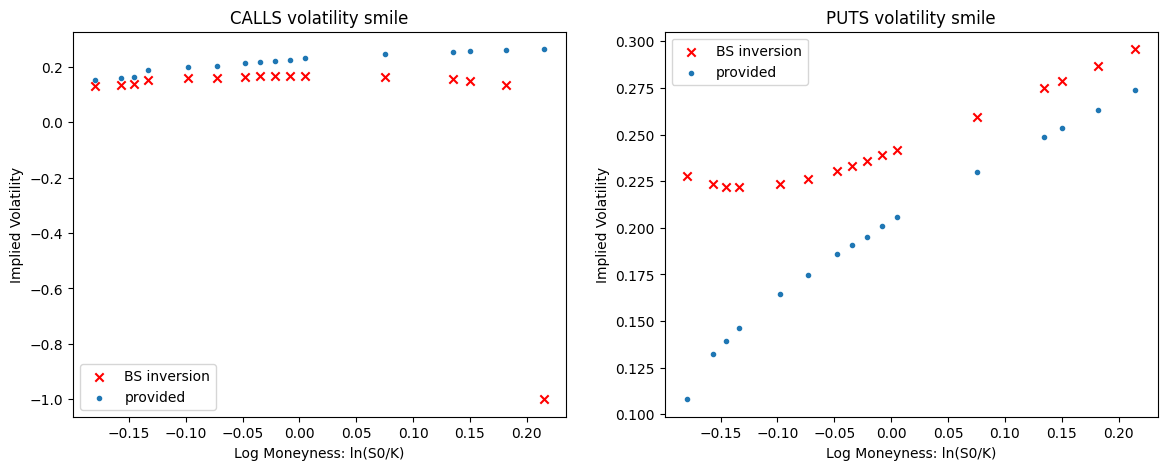

In [11]:
# Plot market implied volatilities w.r.t. log moneyness
x = np.log(S0/put_strikes)
# IV_filtered = [iv for iv in IV_market_p if iv != -1]
# x_filtered = [log_m for iv, log_m in zip(IV_market_p, x) if iv != -1]
IV_filtered = [iv for iv in IV_market_c if iv != -1]
x_filtered = [log_m for iv, log_m in zip(IV_market_c, x) if iv != -1]

fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

#CALLS
ax1.scatter(x, IV_market_c, marker='x', label='BS inversion', color='red')
ax1.scatter(x, calls['C_IV'], marker='.', label='provided')

#PUTS
ax2.scatter(x, IV_market_p, marker='x', label='BS inversion', color = 'red')
ax2.scatter(x, puts['P_IV'], marker= '.', label='provided')

ax1.set_xlabel('Log Moneyness: ln(S0/K)'); ax1.set_ylabel('Implied Volatility'); ax1.set_title('CALLS volatility smile')
ax2.set_xlabel('Log Moneyness: ln(S0/K)'); ax2.set_ylabel('Implied Volatility')
ax2.set_title('PUTS volatility smile')
ax1.legend(); ax2.legend(); plt.show()


Therefore, we can compute the implied volatilities taking into account the theoretical **call prices**..

In [12]:
strikes = call_th_prices['Strike'].tolist(); IV_BS = []; IV_M = []; IV_K = []; IV_VG = []

for i in range(len(call_th_prices)):
    IV_BS.append(implied_volatility(call_th_prices['BlackScholes'].iloc[i], S=S0, strike=strikes[i], t=T, rate=r,q=q, type_o='call', method='newton') )
    IV_M.append(implied_volatility(call_th_prices['Merton'].values[i], S=S0, strike = strikes[i], t=T, rate=r, q=q,  type_o='call', method='newton'))
    IV_K.append(implied_volatility(call_th_prices['Kou'].values[i], S=S0, strike = strikes[i], t=T, rate=r, q=q,  type_o='call', method='newton'))
    IV_VG.append(implied_volatility(call_th_prices['VarianceGamma'].values[i], S=S0, strike=strikes[i], t = T, rate=r, q=q, type_o='call', method='newton'))

imp_vol_call = pd.DataFrame(columns=['Strike', 'BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
imp_vol_call['Strike'] = strikes
imp_vol_call['BlackScholes'] = IV_BS
imp_vol_call['Merton'] = IV_M
imp_vol_call['Kou'] = IV_K
imp_vol_call['VarianceGamma'] = IV_VG

print(f'Implied volatilities found by each model for call options:\n{imp_vol_call.head(7)}')

Implied volatilities found by each model for call options:
   Strike  BlackScholes    Merton       Kou  VarianceGamma
0  1475.0           0.2  0.312980  0.203561       0.152474
1  1525.0           0.2  0.298670  0.195496       0.154609
2  1550.0           0.2  0.291784  0.191747       0.155819
3  1575.0           0.2  0.285077  0.188218       0.157110
4  1625.0           0.2  0.272220  0.181881       0.159881
5  1725.0           0.2  0.248958  0.172269       0.165856
6  1775.0           0.2  0.238715  0.168940       0.168914


... and **put prices**.

In [13]:
strikes = put_th_prices['Strike'].tolist(); IV_BS = []; IV_M = []; IV_K = []; IV_VG = []

for i in range(len(put_prices)):
    IV_BS.append(implied_volatility(put_th_prices['BlackScholes'].values[i], S=S0, strike=strikes[i], t=T, rate=r, q=q, type_o='put', method='newton' ) )
    IV_M.append(implied_volatility(put_th_prices['Merton'].values[i], S=S0, strike = strikes[i], t=T, rate=r, q=q, type_o='put', method='fsolve'))
    IV_K.append(implied_volatility(put_th_prices['Kou'].values[i], S=S0, strike = strikes[i], t=T, rate=r, q=q, type_o='put', method='fsolve'))
    IV_VG.append(implied_volatility(put_th_prices['VarianceGamma'].values[i], S=S0, strike=strikes[i], t = T, rate=r, q=q, type_o='put', method='newton'))

imp_vol_put = pd.DataFrame(columns=['Strike','BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
imp_vol_put['Strike'] = strikes
imp_vol_put['BlackScholes'] = IV_BS
imp_vol_put['Merton'] = IV_M
imp_vol_put['Kou'] = IV_K
imp_vol_put['VarianceGamma'] = IV_VG

print(f'Implied volatilities found by each model for put options:\n {imp_vol_put.head(7)}')

Implied volatilities found by each model for put options:
    Strike  BlackScholes    Merton       Kou  VarianceGamma
0  1500.0           0.2  0.202644  0.199442       0.153490
1  1550.0           0.2  0.195628  0.191747       0.155819
2  1600.0           0.2  0.188416  0.184925       0.158468
3  1625.0           0.2  0.184756  0.181881       0.159881
4  1725.0           0.2  0.169934  0.172269       0.165856
5  1850.0           0.2  0.151107  0.165564       0.173459
6  1875.0           0.2  0.147206  0.164822       0.174949


In [14]:
print('Total absolute error IV from CALLS vs IV from PUTS: ')
print(f'> BS: ', np.linalg.norm(imp_vol_put['BlackScholes'] - imp_vol_call['BlackScholes'], 1))
print(f'> MERTON: ', np.linalg.norm(imp_vol_put['Merton'] - imp_vol_call['Merton'], 1))
print(f'> KOU: ', np.linalg.norm(imp_vol_put['Kou'] - imp_vol_call['Kou'], 1))
print(f'> VG: ', np.linalg.norm(imp_vol_put['VarianceGamma'] - imp_vol_call['VarianceGamma'], 1))

Total absolute error IV from CALLS vs IV from PUTS: 
> BS:  0.0
> MERTON:  4.885563220365003
> KOU:  0.054684485715780745
> VG:  0.06954765936179019


##### Plot

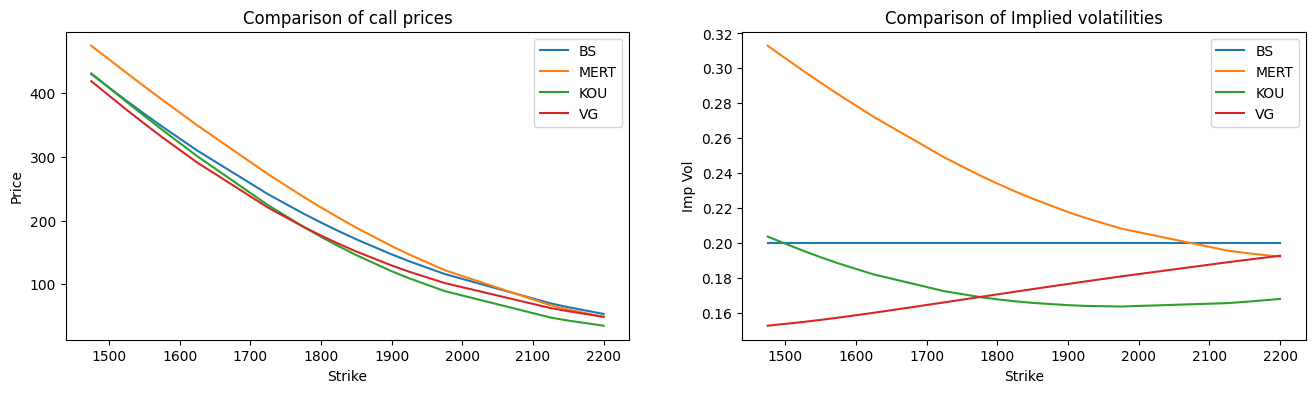

In [15]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(call_strikes, call_th_prices['BlackScholes'], label="BS"); ax1.plot(call_strikes, call_th_prices['Merton'], label="MERT")
ax1.plot(call_strikes, call_th_prices['Kou'], label="KOU"); ax1.plot(call_strikes, call_th_prices['VarianceGamma'], label="VG")
ax1.set_title("Comparison of call prices"); ax1.set_xlabel("Strike"); ax1.set_ylabel("Price")

ax2.plot(call_strikes, imp_vol_call['BlackScholes'], label="BS"); ax2.plot(call_strikes, imp_vol_call['Merton'], label="MERT")
ax2.plot(call_strikes, imp_vol_call['Kou'], label="KOU"); ax2.plot(call_strikes, imp_vol_call['VarianceGamma'], label="VG")
ax2.set_title("Comparison of Implied volatilities"); ax2.set_xlabel("Strike"); ax2.set_ylabel("Imp Vol")

ax1.legend(); ax2.legend(); plt.show()

##  Calibration
Let's step now into the calibration of model parameters.
If we define $\Theta$ the set of parameters, the goal is to find the optimal parameters $\Theta^*$ that minimize the following objective function:
$$ \sum_{i=1}^{N} \biggl( P_i - f(K_i|\Theta) \biggr)^2 $$
where $P_i$ are the market prices and  $f$ is the pricing function. In our case $f$ is given by **Merton** Jump Diffusion model, **Kou** Jump Diffusion model, or **Variance Gamma** process. To perfrom this optimization problem, many numerical methods can be used. In oarticular, we test two functions of `scipy.optimize`:
1. **curve_fit**, a least-squares curve fitting method which works both with and without bounds. When bounds are set it uses the [Trust Region Reflective (trf)](https://en.wikipedia.org/wiki/Trust_region) and the [Levemberg-Marquadt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) when they are not.
2. **minimize(method='SLSQP')**, a constrained minimization problem which uses [Sequential Quadratic Programming](https://en.wikipedia.org/wiki/Sequential_quadratic_programming).
First we initialize a starting point in the array $x_0 = [σ, λ, m, v]$, then we set


### Black and Scholes model
The only unknown parameter to calibrate in Black and Scholes model is the **implied volatility**, $\sigma$. Thus, we minimize the difference between the computed theoretical prices and the market prices of both call and put options.

In [16]:
x0 = 0.4
bounds =( [0], [np.inf])

# CALL OPTIONS
def f_BlackScholes_call(x, sigm):
    BS = BS_Pricer(S0=S0, K = x, ttm=T, r=r, q=0, sigma=sigm, exercise='call')
    return BS.closed_formula_call(x)

res1_calls = scpo.curve_fit(f_BlackScholes_call, call_strikes, call_prices, p0 = x0, bounds=bounds)
sigt_c = round(res1_calls[0][0],4)
print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatility from Calls [σ] = {sigt_c} \t {round(sigt_c*100,2)}%')

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatility from Calls [σ] = 0.1564 	 15.64%


In [17]:
# CALL OPTIONS
params = {'sigma': {'x0': 0.4, 'lbub': [1e-3, 2]}}
x0 = 0.5
bnds = [1e-5, 2]

def cost_function(x, strikes, mkt_prices):
    sigma = x
    BS = BS_Pricer(S0=S0, K = None, ttm=T, r=r, q=0, sigma=sigma, exercise='put')
    sq_err = np.sum( (BS.closed_formula_call(strikes) - mkt_prices)**2)
    return sq_err

result_c = scpo.least_squares(cost_function, x0, args=(call_strikes, call_prices), bounds=bnds, method = 'trf', verbose=2)
opt_sigma_c = result_c.x[0]
print('METHOD 2: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatility from Calls [σ] = {opt_sigma_c} \t {round(opt_sigma_c*100,2)}%')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.3252e+11                                    2.00e+12    
       1              2         5.0933e+10      2.82e+11       1.25e-01       3.65e+11    
       2              3         7.1927e+09      4.37e+10       8.19e-02       6.42e+10    
       3              4         9.1859e+08      6.27e+09       5.37e-02       1.08e+10    
       4              5         1.0498e+08      8.14e+08       3.48e-02       1.73e+09    
       5              6         1.1037e+07      9.39e+07       2.22e-02       2.61e+08    
       6              7         1.2525e+06      9.78e+06       1.43e-02       3.59e+07    
       7              8         3.0710e+05      9.45e+05       1.10e-02       1.47e+06    
       8             12         3.0260e+05      4.51e+03       7.26e-04       4.90e+05    
       9             13         3.0254e+05      5.44e+01       7.24e-04       5.47e+06    

In [18]:
# PUT OPTIONS
#params = {'sigma': {'x0': 0.4, 'lbub': [1e-3, 2]}}
x0 = 0.4
bnds = [1e-3, 2]

def cost_function(x, strikes, mkt_prices):
    sigma = x
    BS = BS_Pricer(S0=S0, K = None, ttm=T, r=r, q=0, sigma=sigma, exercise='put')
    sq_err = np.sum( (BS.closed_formula_put(strikes) - mkt_prices)**2)
    return sq_err

result_p = scpo.least_squares(cost_function, x0, args=(put_strikes, put_prices), bounds=bnds, method = 'trf', verbose=2)
opt_sigma_p = result_p.x[0]

print('METHOD 2: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatility from Puts [σ] = {opt_sigma_p} \t {round(opt_sigma_p*100,2)}%')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2290e+10                                    1.37e+11    
       1              2         1.3918e+09      1.09e+10       6.08e-02       2.21e+10    
       2              3         1.4201e+08      1.25e+09       3.78e-02       3.35e+09    
       3              4         1.4662e+07      1.27e+08       2.35e-02       4.71e+08    
       4              5         2.4737e+06      1.22e+07       1.62e-02       4.65e+07    
       5              7         2.0019e+06      4.72e+05       6.27e-03       3.05e+07    
       6             10         1.9987e+06      3.23e+03       1.01e-03       2.84e+06    
       7             11         1.9977e+06      9.45e+02       9.70e-05       2.14e+06    
       8             12         1.9966e+06      1.09e+03       1.94e-04       7.41e+05    
       9             13         1.9966e+06      3.30e+01       1.94e-04       4.47e+06    

### Merton Jump Diffusion
The Merton Jump diffusion ones are the volatility $\sigma$, the Poisson rate of jumps $\lambda$, the mean rate of jump intensity $m$ and its variance rate $v$, assuming that the intensity of jumps follows a *Normal distribution*.


##### Method 1. Bounds

In [19]:
x0 = [0.15, 1, 0.1, 1] # initial guess: [σ, λ, m, v]
bounds = ( [0, 1e-2, -10, 0.1], [np.inf, np.inf, 10, 5] )

def f_Mert(x, sigma, lambd, meanJ, stdJ):
    Mert = Merton_pricer(S0=S0, K=x, ttm=T, r=r, q=0, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise=exercise)
    return Mert.closed_formula_call(x)

start=time.time()
res1 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0, bounds=bounds)
end = time.time()

sigt = round(res1[0][0],4)
lambdt = round(res1[0][1],2)
mt = round(res1[0][2],2)
vt = round(res1[0][3],5)

print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {sigt} \t {round(sigt*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', lambdt)
print('> Calibrated Jump Mean = ', mt)
print('> Calibrated Jump St. dev.  = ', vt)
print(f'TIME ELAPSED:  {round(end-start,2)} sec')

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.1248 	 12.48%
> Calibrated Jump intensity [λ] =  0.61
> Calibrated Jump Mean =  -0.08
> Calibrated Jump St. dev.  =  0.1
TIME ELAPSED:  6.06 sec


##### Method 2. Least-squares

In [20]:
x0 = [0.4, 1, -0.1, 0.2]      # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 1e-2, -10, 0], [2, np.inf, 10, 5] )

start = time.time()
def cost_function(x, strikes, mkt_prices):
    sigma, lambd, meanJ, stdJ = x
    M = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
    sq_err = np.sum( (M.closed_formula_call(strikes) - mkt_prices)**2)
    return sq_err

result_c = scpo.least_squares(cost_function, x0, args=(call_strikes, call_prices), bounds=bounds, method = 'trf', verbose=1)
end = time.time()
mert_opt_params2 = result_c.x

The maximum number of function evaluations is exceeded.
Function evaluations 400, initial cost 1.7397e+11, final cost 1.9560e+05, first-order optimality 7.45e+05.


In [21]:
print(result_c.x)
print('METHOD 1: LEAST SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {mert_opt_params2[0]} \t {round(mert_opt_params2[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert_opt_params2[1],2))
print('> Calibrated Jump Mean = ', round(mert_opt_params2[2],3))
print('> Calibrated Jump St. dev.  = ', round(mert_opt_params2[3],3))
print(f'TIME ELAPSED:  {round(end-start,2)} sec')


[ 0.1175539   0.88331968 -0.07975604  0.08497628]
METHOD 1: LEAST SQUARES (trf)
> Calibrated Volatlity [σ] = 0.11755389816663356 	 11.76%
> Calibrated Jump intensity [λ] =  0.88
> Calibrated Jump Mean =  -0.08
> Calibrated Jump St. dev.  =  0.085
TIME ELAPSED:  52.4 sec


##### Method 2. Bounds

In [ ]:
x0 = [0.3, 0.8, -0.3, 0.4]      # initial guess: [σ, λ, m, v]
bounds = [(1e-6, 10), (0, 20), (-10, 10),  (0, 15)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, lamb, mean, std = x
    Mert = Merton_pricer(S0=S0, K=strikes, ttm=T, r=r, q=0, sigma=sigm, lambd=lamb, meanJ=mean, stdJ=std, exercise=exercise)
    return np.sum((Mert.closed_formula_call(K) - prices) ** 2)

start=time.time()
res2_2 = scpo.minimize(obj_function, x0, args=(call_strikes, call_prices),  method='trust-constr', bounds=bounds, tol=1e-20)
end=time.time()

print(res2_2.message)
sigt4, lambdt4, mt4, vt4 = res2_2.x

# Print the results
print('\n> METHOD 2: MINIMIZE (trust-constr)')
print(f'Calibrated Volatility [σ] = {round(sigt4, 5)}, \t  {round(sigt4*100,2)}%')
print('Calibrated Jump Intensity [λ] =', round(lambdt4, 2))
print('Calibrated Jump Mean [m] =', round(mt4, 2))
print('Calibrated Jump St. dev. [v] =', round(vt4, 2))
print(f'\nTIME ELAPSED:  {round(end-start,2)} sec')

In [ ]:
mert_params = [sigt, lambdt, mt, vt]
print(mert_params)

### Kou Jump Diffusion


In [22]:
x0 = [0.1, 1, 0.4, 5, 5] # initial guess: [σ, λ, p, η_1, η_2]
bounds = ( [1e-3, 1e-2, 0, 0, 0], [2, 5, 0.99,  15, 15] )

##### Method 1. TRF (Bounds)

In [23]:
def f_Kou(x, sigma, lambd, p, eta1, eta2):
    KouJD = Kou_pricer(S0=S0, K=x, ttm=T, r=r, sigma=sigma, lambd=lambd, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    return KouJD.closed_formula_call(x)

start = time.time()
res1 = scpo.curve_fit(f_Kou, call_strikes, call_prices, p0=x0, bounds=bounds)
end = time.time()

sigt = round(res1[0][0],5)
lambdt = round(res1[0][1],2)
pt = round(res1[0][2],2)
eta1_t = round(res1[0][3],1)
eta2_t = round(res1[0][4],1)

print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {sigt} \t {round(sigt*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', lambdt)
print(f'> Calibrated Upward Jump probability [p] = {pt}, [q] = {round(1-pt,2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', eta1_t)
print('> Calibrated Rate of Exp. 2  [η_2] = ', eta2_t)
print(f'TIME ELAPSED:  {round(end-start,2)} sec')

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.12632 	 12.63%
> Calibrated Jump intensity [λ] =  1.12
> Calibrated Upward Jump probability [p] = 0.0, [q] = 1.0
> Calibrated Rate of Exp. 1  [η_1] =  15.0
> Calibrated Rate of Exp. 2  [η_2] =  15.0
TIME ELAPSED:  127.7 sec


##### Method 2. LEAST SQUARES (With Bounds)

In [25]:
# Define the objective function
def cost_function(x, strikes, mkt_prices):
    sigm, lamb, p, eta1, eta2 = x
    KOU = Kou_pricer(S0=S0, K=strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    sq_err = np.sum((KOU.closed_formula_call(strikes) - mkt_prices) ** 2)
    return sq_err

In [ ]:
start=time.time()
res2 = scpo.least_squares(cost_function, x0, args=(call_strikes, call_prices),  method='trf', bounds=bounds, verbose=2)
end=time.time()

kou_opt_params2 = res2.x
print('METHOD 2: Least-squares')
print(f'> Calibrated Volatlity [σ] = {round(kou_opt_params2[0],4)} \t {round(kou_opt_params2[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(kou_opt_params2[1],2))
print(f'> Calibrated Upward Jump probability [p] = {round(kou_opt_params2[2],2)}, [q] = {round(1-kou_opt_params2[2],2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(kou_opt_params2[3],2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(kou_opt_params2[4],2))
print(f'TIME ELAPSED:  {round(end-start,2)} sec')

##### Method 3: MINIMIZE (trust-constrained) Bounds

In [26]:
x0 = [0.15, 1, 0.4, 5, 5]
bounds = [(1e-1, 1), (1e-2, 10), (0,1), (0,15), (0,15)]
start=time.time()
res3 = scpo.minimize(cost_function, x0, args=(call_strikes, call_prices),  method='trust-constr', bounds=bounds, tol=1e-20)
end=time.time()
print('METHOD 3: MINIMIZE (trust-constr)'); print(f'message: {res3.message}\nsuccess:{res3.success}')

sigt3, lambdt3, pt3, eta1_t3, eta2_t3 = res3.x

print(f'> Calibrated Volatlity [σ] = {round(sigt3,4)} \t {round(sigt3*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(lambdt3,2))
print(f'> Calibrated Upward Jump probability [p] = {round(pt3,2)}, [q] = {round(1-pt3,2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(eta1_t3,2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(eta2_t3,2))
print(f'TIME ELAPSED:  {round(end-start,2)} sec')

KeyboardInterrupt: 

Print parameters to use in the simulation of paths.

In [ ]:
kou_params = [sigt, lambdt, pt, eta1_t, eta2_t]
print(kou_params)

### Variance Gamma


In [ ]:
x0 = [0.2, -0.05, 0.1]   # initial guess: [σ, θ, v]
bounds = ( [1e-2, -10, 0], [5, 10, 10] )

##### Method 1. CURVE FIT (Bounds)

In [ ]:
def f_VG(strikes, sigmax, thetax, nux):
    VGamma = VG_pricer(S0=S0, K=None, ttm=T, r=r, q=0, sigma=sigmax, theta=thetax, nu=nux, exercise=exercise)
    vg_prices = []
    for k in strikes:
        vg_prices.append(VGamma.closed_formula_call(k))
    return vg_prices

start=time.time()
res1 = scpo.curve_fit(f_VG, call_strikes, call_prices, p0=x0, bounds=bounds)
end=time.time()

sigt = round(res1[0][0],5)
thetat = round(res1[0][1],2)
nut = round(res1[0][2],2)

print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {sigt}, \t {round(sigt*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', thetat)
print('> Calibrated variance rate gamma process [v]= ', nut)
print(f'TIME ELAPSED:  {round(end-start,2)} sec')

##### Method 2. LEAST-SQUARES (Trust Region Reflective, Bounds)

In [ ]:
def cost_function(x, strikes, mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
    prices = []
    for k in strikes:
        prices.append(VG.closed_formula_call(k))
    sq_err = np.sum((prices - mkt_prices)**2)
    return sq_err

start=time.time()
res2 = scpo.least_squares(cost_function, x0, args=(call_strikes, call_prices),  method='trf', bounds=bounds, verbose=2)
end=time.time()

vg_opt_params2 = res2.x

print('METHOD 1: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_opt_params2[0]}, \t {round(vg_opt_params2[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_opt_params2[1])
print('> Calibrated variance rate gamma process [v]= ', vg_opt_params2[2])
print(f'TIME ELAPSED:  {round(end-start,2)} sec')

In [ ]:
print(vg_opt_params2)

##### Method 2. MINIMIZE (Bounds)

In [ ]:
bounds  = [(1e-3, 2), (-10, 10), (0, 15)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, theta, nu = x
    VGx = VG_pricer(S0=S0, K=strikes, ttm=T, r=r, q=0, sigma=sigm, theta=theta, nu=nu, exercise=exercise)
    return np.sum((VGx.closed_formula_call(K) - prices) ** 2)

# METHOD TRUST REGION CONSTRAINED
res3 = scpo.minimize(obj_function, x0, args=(call_strikes, call_prices),  method='trust-constr', bounds=bounds, tol=1e-20)
print('METHOD 2: MINIMIZE (trust-constr)'); print(f'message: {res3.message}\nsuccess: {res3.success}')
sigt3, thetat3, nut3 = res3.x

# Print the results
print(f'> Calibrated Volatlity [σ] = {round(sigt3,4)} \t {round(sigt3*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', round(thetat3,2))
print('> Calibrated variance rate gamma process [v]= ', round(nut3,2))
print(f'TIME ELAPSED:  {round(end-start,2)} sec')

##### Method 1 using FFT prices

In [ ]:
def f_VG_fft(strikes, sigmax, thetax, nux):
    VGamma = VG_pricer(S0=S0, K=None, ttm=T, r=r, q=0, sigma=sigmax, theta=thetax, nu=nux, exercise=exercise)
    return VGamma.FFT_call(strikes)

res4 = scpo.curve_fit(f_VG_fft, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt4 = round(res1[0][0],5)
thetat4 = round(res1[0][1],2)
nut4 = round(res1[0][2],2)

print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {round(sigt4,4)} \t {round(sigt4*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', thetat4)
print('> Calibrated variance rate gamma process [v]= ', nut4)

In [ ]:
vg_params = [sigt, thetat, nut]
print(vg_params)

## Weighted calibration (CALLS)
Considering the original formula of the calibration, we can add a weight parameter $w_i$ that allows to give more importance to the market prices with smaller spread. Thus, the optimization objective function  becomes:
$$ \sum_{i=1}^{N} w_i \biggl( P_i - f(K_i|\Theta) \biggr)^2 $$
where $w_i$ are weights, usually defined as
$$ w_i = \frac{1}{\text {spread}_i }$$


In [ ]:
call_spreads = calls['C_Spread']
#for a, b, c in zip(call_strikes, call_prices, spreads):
#    print(a, b,c )

### Black and Scholes

In [ ]:
x0 = 0.4
bounds =( [0], [np.inf])

# CALL OPTIONS
def f_BlackScholes_call(x, sigm):
    BS = BS_Pricer(S0=S0, K = x, ttm=T, r=r, q=0, sigma=sigm, exercise='call')
    return BS.closed_formula_call(x)

res1_calls = scpo.curve_fit(f_BlackScholes_call, call_strikes, call_prices, p0 = x0, bounds=bounds, sigma= call_spreads)
sigw_c = round(res1_calls[0][0],4)

print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatility from Calls [σ] = {sigw_c} \t {round(sigw_c*100,2)}%')

### Merton Jump diffusion

In [ ]:
# using call prices
def f_Mert(x, sigma, lambd, meanJ, stdJ):
    Mert = Merton_pricer(S0=S0, K=x, ttm=T, r=r, q=0, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise=exercise)
    return Mert.closed_formula_call(x)

x0 = [0.0993,  0.93, -0.097,  0.092]  # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 1e-2, -10, 1e-5], [2, 10, 10, 5] )

start=time.time()
mert_params2 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0, bounds=bounds, sigma=call_spreads)
end=time.time()

In [ ]:
sigw = round(mert_params2[0][0],4)
lambdw = round(mert_params2[0][1],2)
mw = round(mert_params2[0][2],2)
vw = round(mert_params2[0][3],5)

print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {sigw} \t {round(sigw*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', lambdw)
print('> Calibrated Jump Mean = ', mw)
print('> Calibrated Jump St. dev.  = ', vw)
print(f'\nELAPSED TIME: {end-start} sec')

mert_params2 = [sigw, lambdw, mw, vw]

In [ ]:
print(mert_params2)

### Kou Jump Diffusion

In [ ]:
def f_Kou(x, sigma, lambd, p, eta1, eta2):
    KouJD = Kou_pricer(S0=S0, K=x, ttm=T, r=r, sigma=sigma, lambd=lambd, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    return KouJD.closed_formula_call(x)

x0 = [0.1, 0.5, 0.4, 5, 5] # initial guess: [σ, λ, p, η_1, η_2]
bounds = ( [0, 1e-2, 0, 0, 0], [4, 10, 0.9,  100, 100] )

start=time.time()
kou_params2 = scpo.curve_fit(f_Kou, call_strikes, call_prices, p0=x0, bounds=bounds, sigma=call_spreads)
end=time.time()

In [ ]:
sigw = round(kou_params2[0][0],5)
lambdw = round(kou_params2[0][1],2)
pw = round(kou_params2[0][2],2)
eta1_w = round(kou_params2[0][3],1)
eta2_w = round(kou_params2[0][4],1)

print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {sigw} \t {sigw*100}%')
print('> Calibrated Jump intensity [λ] = ', lambdw)
print(f'> Calibrated Upward Jump probability [p] = {pw}, [q] = {round(1-pw,2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', eta1_w)
print('> Calibrated Rate of Exp. 2  [η_2] = ', eta2_w)

kou_params2 = [sigw, lambdw, pw, eta1_w, eta2_w]
print(kou_params2)

### Variance Gamma

In [ ]:
def f_VG(strikes, sigmax, thetax, nux):
    VGamma = VG_pricer(S0=S0, K=None, ttm=T, r=r, q=0, sigma=sigmax, theta=thetax, nu=nux, exercise=exercise)
    vg_prices = []
    for k in strikes:
        vg_prices.append(VGamma.closed_formula_call(k))
    return vg_prices

x0 = [0.2, -0.05, 0.1]   # initial guess: [σ, θ, v]
bounds = ( [1e-2, -10, 0], [5, 10, 20] )
vg_params2 = scpo.curve_fit(f_VG, call_strikes, call_prices, p0=x0, bounds=bounds, sigma=call_spreads)

In [ ]:
sigw = round(vg_params2[0][0],5)
thetaw = round(vg_params2[0][1],2)
nuw = round(vg_params2[0][2],2)

print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {sigw}, \t {round(sigw*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', thetaw)
print('> Calibrated variance rate gamma process [v]= ', nuw)

vg_params2 = [sigw, thetaw, nuw]

In [ ]:
print(vg_params2)

## Weighted calibration (PUTS)

In [ ]:
put_spreads = puts['P_Spread']

#### Black and Scholes

In [ ]:
x0 = 0.4
bounds =( [0], [np.inf])

# PUT OPTIONS
def f_BlackScholes(x, sigm):
    BS = BS_Pricer(S0=S0, K = x, ttm=T, r=r, q=0, sigma=sigm, exercise='put')
    return BS.closed_formula_put(x)

res1_puts = scpo.curve_fit(f_BlackScholes, put_strikes, put_prices, p0 = x0, bounds=bounds, sigma = put_spreads)
sigw_p = round(res1_puts[0][0],4)

print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatility from Puts [σ] = {sigw_p} \t {round(sigw_p*100,2)}%')

### Merton Jump diffusion


In [ ]:
# put prices
def f_Mert(x, sigma, lambd, meanJ, stdJ):
    Mert = Merton_pricer(S0=S0, K=x, ttm=T, r=r, q=0, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise=exercise)
    return Mert.closed_formula_put(x)

x0 = [0.4, 1, 0.1, 1] # initial guess: [σ, λ, m, v]
bounds = ( [1e-2, 1e-2, -10, 0.1], [2, np.inf, 10, 5] )

start=time.time()
mert_params3 = scpo.curve_fit(f_Mert, put_strikes, put_prices, p0=x0, bounds=bounds, sigma=put_spreads)
end=time.time()

In [ ]:
sigw_p = round(mert_params3[0][0],4)
lambdw_p = round(mert_params3[0][1],2)
mw_p = round(mert_params3[0][2],2)
vw_p = round(mert_params3[0][3],5)

print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {sigw_p} \t {sigw_p*100}%')
print('> Calibrated Jump intensity [λ] = ', lambdw_p)
print('> Calibrated Jump Mean = ', mw_p)
print('> Calibrated Jump St. dev.  = ', vw_p)
print(f'\nELAPSED TIME: {end-start} sec')

mert_params3 = [sigw_p, lambdw_p, mw_p, vw_p]

In [ ]:
print(mert_params3)

### Kou Jump Diffusion

In [ ]:
def f_Kou(x, sigma, lambd, p, eta1, eta2):
    KouJD = Kou_pricer(S0=S0, K=x, ttm=T, r=r, sigma=sigma, lambd=lambd, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    return KouJD.closed_formula_put(x)

x0 = [0.1, 0.5, 0.5, 5, 5] # initial guess: [σ, λ, p, η_1, η_2]
bounds = ( [0, 1e-3, 0, 0, 0], [4, 10, 0.9,  10, 10] )
start = time.time()
kou_params3 = scpo.curve_fit(f_Kou, put_strikes, put_prices, p0=x0, bounds=bounds, sigma=put_spreads)
end=time.time()

In [ ]:
sigw_p = round(kou_params3[0][0],5)
lambdw_p = round(kou_params3[0][1],2)
pw_p = round(kou_params3[0][2],2)
eta1_w_p = round(kou_params3[0][3],1)
eta2_w_p = round(kou_params3[0][4],1)

print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {sigw_p} \t {round(sigw_p*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', lambdw_p)
print(f'> Calibrated Upward Jump probability [p] = {pw_p}, [q] = {round(1-pw_p,2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', eta1_w_p)
print('> Calibrated Rate of Exp. 2  [η_2] = ', eta2_w_p)
print(f'\nELAPSED TIME: {end-start} sec')

kou_params3 = [sigw_p, lambdw_p, pw_p, eta1_w_p, eta2_w_p]
print(kou_params3)

### Variance Gamma

In [ ]:
def f_VG(strikes, sigmax, thetax, nux):
    VGamma = VG_pricer(S0=S0, K=None, ttm=T, r=r, q=0, sigma=sigmax, theta=thetax, nu=nux, exercise=exercise)
    vg_prices = []
    for k in strikes:
        vg_prices.append(VGamma.closed_formula_put(k))
    return vg_prices

x0 = [0.2, -0.05, 0.1]   # initial guess: [σ, θ, v]
bounds = ( [1e-2, -10, 0], [5, 10, 20] )
vg_params3 = scpo.curve_fit(f_VG, put_strikes, put_prices, p0=x0, bounds=bounds, sigma=put_spreads)

In [ ]:
sigw_p = round(vg_params3[0][0],5)
thetaw_p = round(vg_params3[0][1],2)
nuw_p = round(vg_params3[0][2],2)

print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {sigw_p}, \t {round(sigw_p*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', thetaw_p)
print('> Calibrated variance rate gamma process [v]= ', nuw_p)

vg_params3 = [sigw_p, thetaw_p, nuw_p]

In [ ]:
print(vg_params3)

### Monte Carlo Option Pricing and Calibration
The following code snippet aims to find the best parameters for each model, minimizing the difference between the monte carlo prices and the market prices of **call** and **put** options.

#### Black and Scholes Model

In [ ]:
# Define the objective function
def obj_function(x, strikes, mkt_prices, days=252, N=100):
    sigm = x
    BS = BS_Pricer(S0,r,q,sigm, T, exercise=exercise, K=None)
    bs_prices = []
    for k in strikes:
        bs_prices.append(BS.MonteCarlo_Call(k,251, days, N))
    diff = bs_prices - mkt_prices
    return np.sum(diff**2)

additional_args = (call_strikes, call_prices)

x0 = 0.20

# METHOD SEQUENTIAL LEAST SQUARES
res_bs = scpo.minimize(obj_function, x0, args=additional_args,  method='BFGS')


In [ ]:
sigma_opt = res_bs.x
print(sigma_opt)